# Spectral analysis of 5000 movies network
### by Macko Vladimir, Novakovic Milica, Pavué Clément, Roussaky Mehdi

## Goal of the Project:


The aim is to create a graph in which nodes represent movies and edges represent similarity between the movies they are connecting. Described graph represents a network of movies and their relations using descriptions of 5000 selected movies leading to movie genre classification, suggestion of the best movie to represent the genre and quantifying how much $mainstream$ the movie is. 

## Data Acquisition:

The starting point is TMDB 5000 Movie Dataset, available at Kaggle web page, contains information about 5000 selected movies provided by users and reviewers from The Movie Database (TMDb). Namely,
each of the selected movies has the following attributes: budget, genres, homepage, id,
keywords, original language, original title, overview, popularity, production companies,
production coutries, release data, revenue and personnel aspects of cast and crew members listing their names, genders and role or contribution to the movie production and
other details. The majority of the data is in the text format encoded in JSON structure. 

Since the files in JSON format are not practical for manipulations, one single dataset is prapered in Pandas data-frame structure from 2 original JSON datafiles. During this preparation the data is cleaned, e.g. unuseful collumns are removed and corrupted lines (which have missing movie title or other issues are removed), it was examined that there are no duplicates in the produced dataset.

In [1]:
#classical inputs
import sys, os, pathlib

import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
import seaborn as sns
import matplotlib
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score


#setting the path to folder with modules
sys.path.insert(0, str(pathlib.Path(os.getcwd()).parents[0] / 'python'))

#custom functions
from GetWeights import *
from Load_Datasets import *
from ProcessCategorical import *
from DropZeroLinesAndGetDistanes import *
from PlotMatrix import *
from BubbleReorderMatrix import *
from matchLabel import *

#Loading information about movies (transforming JSON files into pandas frame)
FileAddress_movies ="../Datasets/tmdb_5000_movies.csv"
FileAddress_credits="../Datasets/tmdb_5000_credits.csv"

Custom made function $Load Datasets$ in order to convert JSON database from two input files to one single Pandas dataframe which contains movies as lines and movie attributes as columns. For more details refer to function $Load Datasets$ [implementation](https://github.com/ryancier/FinalProjectNTDS2017/blob/master/python/Load_Datasets.py)


After the first examination of the data, the following movie attributes are considered no usefull for further analysis movie id, production status (since the vast majority of movies are are released and those which are not released have no actors published and hence are subsequently removed) and homepage (since homepage does address does not contains only information which is in the movie title)

In [2]:
#Loading information about movies
Movies = Load_Datasets(FileAddress_movies,FileAddress_credits)

Drops = ['homepage','status','id']
for drop in Drops:
    Movies = Movies.drop(drop, 1)

#pandas entries contain string arrays from which can be easily converted to lists using string.split(",")
#new datafile is generated
Movies.to_csv("../Datasets/Transformed.csv")

Final categoties are below: There is a list of actors for each movies and list of their genders. Also, there is a list of crew names and their job and departement and other movie markers such as movie popularity, revenue, etc.

In [3]:
list(Movies)

['budget',
 'genres',
 'keywords',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'tagline',
 'vote_average',
 'vote_count',
 'genres_id',
 'keywords_id',
 'production_companies_id',
 'actors',
 'actors_id',
 'actor_gender',
 'crew_names',
 'crew_names_id',
 'crew_jobs',
 'crew_departments',
 'primary_genre',
 'primary_production_company',
 'prime_actors',
 'prime_crew_names',
 'prime_keywords']

In [4]:
#Example 
print("Avatar 1st crew member is "+Movies['crew_names']['Avatar'].split(",")[0]
      +", he works at departement "+Movies['crew_departments']['Avatar'].split(",")[0]
      +", and his job is "+Movies['crew_jobs']['Avatar'].split(",")[0])

Avatar 1st crew member is Stephen E. Rivkin, he works at departement Editing, and his job is Editor


After removal of all the movies which are incomplete or not fully released, there are 4809 remaining movie entries in the dataset

In [5]:
len(Movies)

4809

## Data Exploration

Here we will present distributions of different features of the movies, i.e. movies budget, revenue, average vote, vote counts, popularity, number of actors and number of movies cast.

Dataset preview:

In [6]:
Movies.head(1)

,budget,genres,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,...,actor_gender,crew_names,crew_names_id,crew_jobs,crew_departments,primary_genre,primary_production_company,prime_actors,prime_crew_names,prime_keywords
title,,,,,,,,,,,,,,,,,,,,,
#Horror,1500000,"Drama,Mystery,Horror,Thriller",,de,#Horror,"Inspired by actual events, a group of 12 year ...",2.815228,"AST Studios,Lowland Pictures",United States of America,2015-11-20,...,"1,1,1,2,2,1,0,0,1","Tara Subkoff,Tara Subkoff,Tara Subkoff,Jason L...","61111,61111,61111,1382445,1382446,1382448","Screenplay,Director,Producer,Producer,Producer...","Writing,Directing,Production,Production,Produc...",Drama,AST Studios,"Taryn Manning,Natasha Lyonne,Chloë Sevigny,Bal...","Tara Subkoff,Tara Subkoff,Tara Subkoff,Jason L...",


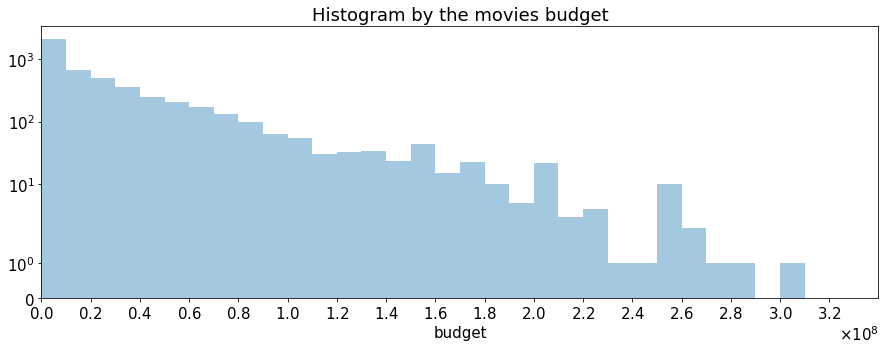

In [7]:
% matplotlib inline
fontsizes = 15
matplotlib.rcParams.update({'font.size': fontsizes})
fig, axes = plt.subplots(figsize=(15, 5))

# Budget is plotted in log scale on y axis
axes.set(yscale="symlog")

# Here we will set appropriate range of values x-axis and binsize so that ticks on x-coordinate correspond to 
# the end of every second bin
# for every other data i.e. reveunue, average vote, etc. the values of bin_size will be specific
# hence this procedure will be conducted for each column of interest

bin_size = 0.1*1e8
bins_hist = np.arange(min(Movies["budget"]), max(Movies["budget"]), bin_size)
g = sns.distplot(Movies['budget'], bins = bins_hist, kde=False, rug=False)
plt.xlim(0*1e8,3.4*1e8)
ticks = np.arange(0*1e8,3.4*1e8,0.2*1e8)
axes.set_xticks(ticks)
g.set(title='Histogram by the movies budget')
g.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useMathText=True, useOffset=False))
plt.show()

Here is presented logarithmic vs. linear scale distribution of movies budget, due to tailed nature of distribution. We can notice there is a lot of movies with low budget less than $10^{8}$, and a small number of movies with budget grater than  $3*10^{8}$

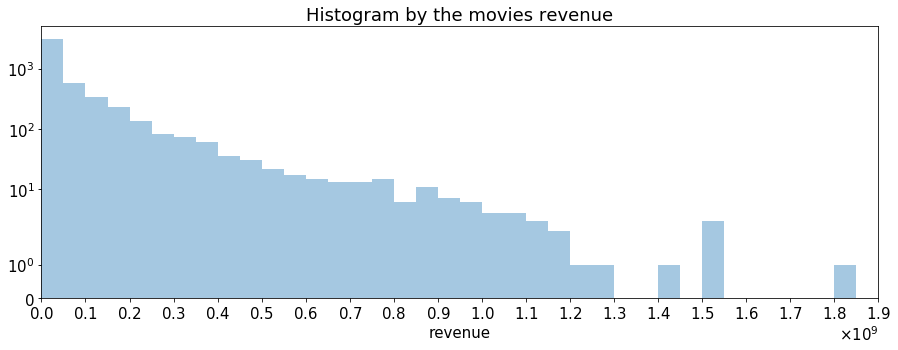

In [8]:
fig, axes = plt.subplots(figsize=(15, 5))
# Revenue is plotted in log scale on y axis
axes.set( yscale="symlog")

# Here we will set appropriate range of values on x-axis and binsize so that ticks on x-coordinate correspond to
# the end of every second bin

bin_size = 0.05*1e9
bins_hist = np.arange(min(Movies["revenue"]), max(Movies["revenue"]), bin_size)
g = sns.distplot(Movies['revenue'], bins = bins_hist, kde=False, rug=False)
plt.xlim(0,1.9*1e9)
g.set(title='Histogram by the movies revenue')
ticks = np.arange(0*1e9,2*1e9,0.1*1e9)
axes.set_xticks(ticks)
g.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useMathText=True, useOffset=False))
plt.show()

The presented distribution has been plotted in logarithmic vs. linear scale, due to tailed nature of data. The revenue of the movie has usually value less than $10^{9}$, the its distribution is haevily tailed.The range of movies revenue is from $(0, 2.8*10^{9})$

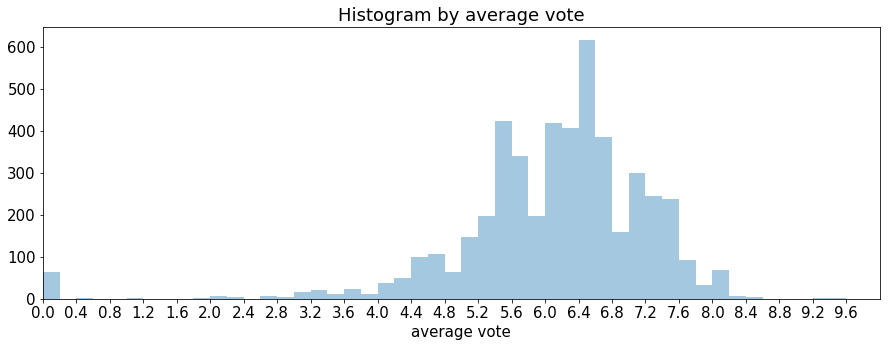

In [9]:
fig, axes = plt.subplots(figsize=(15, 5))

# Here we will set appropriate range of values on x-axis and binsize so that ticks on x-coordinate correspond to
# the end of every second bin

bin_size = 0.2
bins_hist = np.arange(min(Movies["vote_average"]), max(Movies["vote_average"]), bin_size)
g = sns.distplot(Movies['vote_average'], bins = bins_hist, kde=False, rug=False)
plt.xlim(0,10)
ticks = np.arange(0,10,0.4)
axes.set_xticks(ticks)
g.set(title='Histogram by average vote', xlabel = "average vote")
plt.show()

Movies can receive a vote in range 0-10 from user. Average vote is calculated as mean value of all existing votes for that movie. The most frequent vote is less near 6.5. Also, one could notice there is a lot of average_votes in intervals 5.4-5.8, 6.0-6.8, and 7.0-7.6 compared to their "neighbourhood" intervals. There is a lot of movies with vote 0, so it could mean that 0 is written for movies who has not given the vote

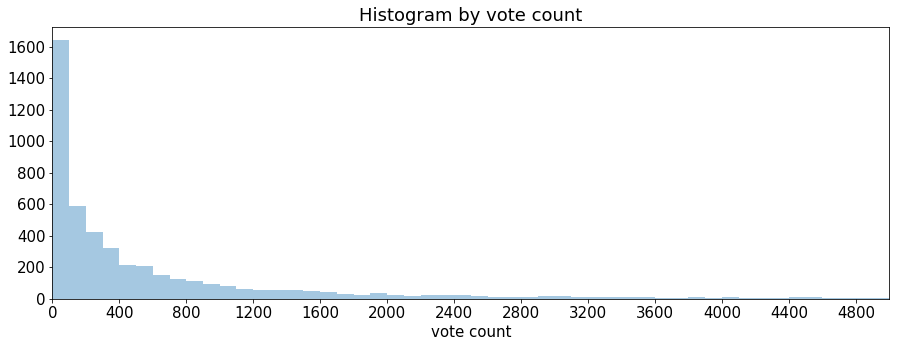

In [10]:
fig, axes = plt.subplots(figsize=(15, 5))

# Here we will set appropriate range of values on x-axis and binsize so that ticks on x-coordinate correspond to
# the end of every fourth bin

bin_size = 100
bins_hist = np.arange(min(Movies["vote_count"]), max(Movies["vote_count"]), bin_size)
g = sns.distplot(Movies['vote_count'], bins = bins_hist, kde=False, rug=False)
plt.xlim(0,5000)
ticks = np.arange(0,5000, 400)
axes.set_xticks(ticks)
g.set(title='Histogram by vote count', xlabel = "vote count")
plt.show()

Distribution of vote count is tailed, usually movies has less than 400 votes, and vast majority has less than 2000 votes

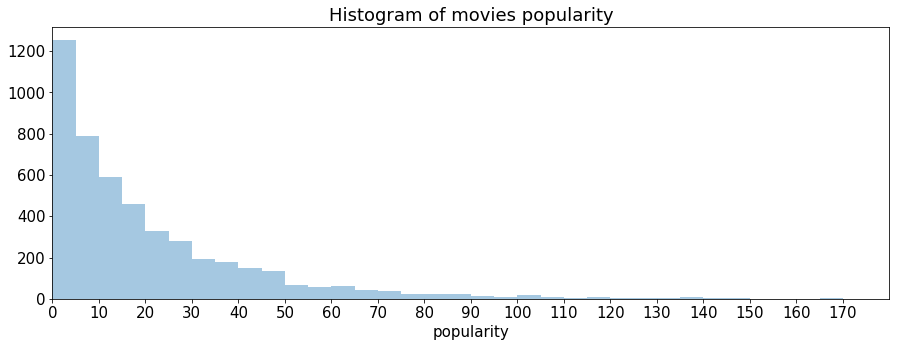

In [11]:
fig, axes = plt.subplots(figsize=(15, 5))

# Here we will set appropriate range of values on x-axis and binsize so that ticks on x-coordinate correspond to
# the end of every second bin

bin_size = 5
bins_hist = np.arange(min(Movies["popularity"]), max(Movies["popularity"]), bin_size)
g = sns.distplot(Movies['popularity'], bins = bins_hist, kde=False, rug=False )
plt.xlim(0,180)
ticks = np.arange(0,180,10)
axes.set_xticks(ticks)
g.set(title='Histogram of movies popularity')
plt.show()

A lot of movies has a low popularity, it seems like 0 is popularity when movie has not given the popularity data 

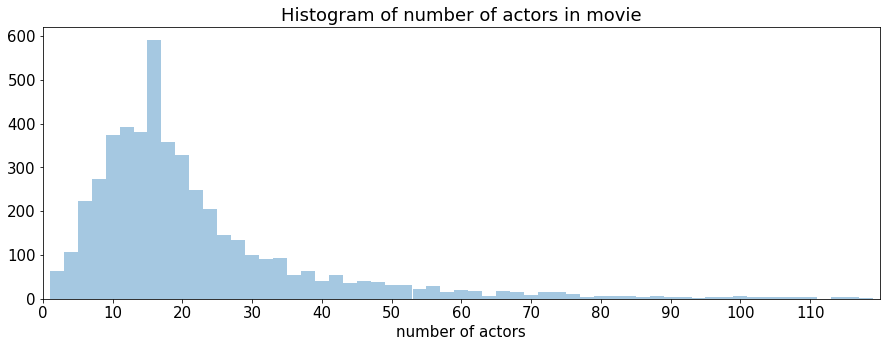

In [12]:
num_of_elements = lambda x: len(x.split(","))
num_of_actors = Movies["actors_id"].apply(num_of_elements)

fig, axes = plt.subplots(figsize=(15, 5))

# Here we will set appropriate range of values on x-axis and binsize so that ticks on x-coordinate correspond to
# the end of every second bin

bin_size = 2
bins_hist = np.arange(min(num_of_actors), max(num_of_actors), bin_size)
g = sns.distplot(num_of_actors, bins=bins_hist, kde=False, rug=False )
plt.xlim(0,120)
ticks = np.arange(0,120,10)
axes.set_xticks(ticks)
g.set(title='Histogram of number of actors in movie', xlabel = "number of actors")
plt.show()

The mode of actors in the movie is 15 or 16, and it does not fit very well in the rest of the distribution. Just a couple of movies has more then 100 actors

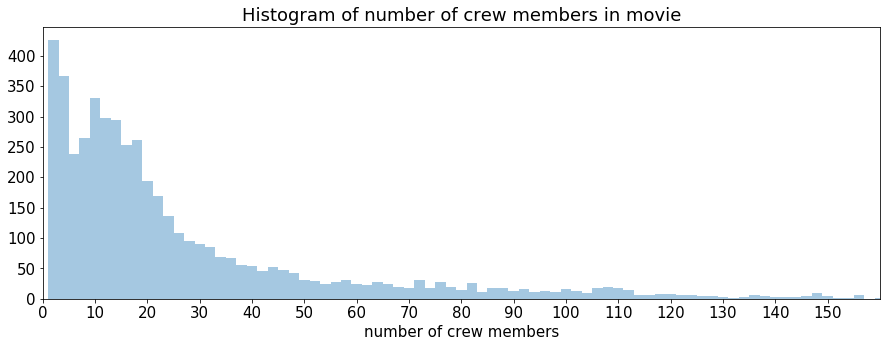

In [13]:
num_of_crew = Movies["crew_names_id"].apply(num_of_elements)

fig, axes = plt.subplots(figsize=(15, 5))

# Here we will set appropriate range of values on x-axis and binsize so that ticks on x-coordinate correspond to
# the end of every fifth bin

bin_size = 2
bins_hist = np.arange(min(num_of_actors), max(num_of_actors), bin_size)
g = sns.distplot(num_of_crew, bins = bins_hist, kde=False, rug=False )
plt.xlim(0,160)
ticks = np.arange(0,160,10)
axes.set_xticks(ticks)
g.set(title='Histogram of number of crew members in movie', xlabel = "number of crew members")
plt.show()

The number of crew members is most times less than 50, and there is some movie up to 200 crew members. It is more frequent to have cast larger than 50 crew members, than 50 actors which is expected

Now, we will find the most frequent keywords, crew members, production companies, actors and genres:

Here is the function which we use for representing most frequent how_much (i.e. 10) production companies and actors. What we are looking for we will call the item in the comments and code i.e. items are production companies or actors

In [14]:
def most_freq_items_with_id(how_much, col, col_id):
    # how_much: how_much top frequent items fo we search for, type:int
    # col: name of the column in Movies dataframe which has also corresponding id column i.e. "production_companies", type:string
    # col_id: name of the column in Movies dataframe with ids
    
    # Due to the fact that the id's as integers are more reliable data than the string type of data
    # we will find most frequent item's ids, and then look for the items name given in the column Movies[col]
    # of course we assume that we have obtained correct match between (items name, items id)

    # Here we will find the number of occurency of each items_id in database,
    # and store it in dictionary items_id_dict in pairs (items_id(type:int):items_name(type:string))
    # we will store in dictionary freq_items_ids in pairs (items_id(type:int):number_of_occurency(type:int))

    items_id_dict = {}
    freq_items_ids = {}
    
    for i in range(len(Movies)):
        for j in range(len(Movies.iloc[i][col_id].split(","))):
            if (len(Movies.iloc[i][col_id].split(",")[j])>0):
                items_id_int_key = int(Movies.iloc[i][col_id].split(",")[j])
                freq_items_ids[items_id_int_key] = freq_items_ids.get(items_id_int_key, 0) + 1
                items_id_dict[items_id_int_key] = Movies.iloc[i][col].split(",")[j]
    
    # Here we will find most how_much frequent items names
    # We will "sort" the dictionary of occurency by values, retrieve the ids of most frequent ones
    # and find corresponding names and store in most_freq_items
 
    how_much_items = how_much; 
    most_freq_ids = sorted(freq_items_ids, key=freq_items_ids.get)[-how_much_items:] #list
    most_freq_items = [items_id_dict[key]  for key in most_freq_ids]

    fig, ax = plt.subplots(figsize=(15,5))

    # in freq_items_plot is stored number_of-occurency in dataset of most frequent items
    freq_items_plot = [freq_items_ids[most_freq_ids[how_much_items-i-1]] for i in range(how_much_items)]
    plt.bar(range(how_much_items), freq_items_plot)
    string_title = col.replace("_"," ")
    plt.title("Most {} frequent ".format(how_much_items)+string_title)
    plt.xticks(range(how_much_items),(most_freq_items[::-1]), rotation=45, rotation_mode="anchor", ha="right")
    for i in ax.patches:
        ax.text(i.get_x()+.1, i.get_height(),str(round((i.get_height()))), fontsize=15, color='black')
    plt.show()

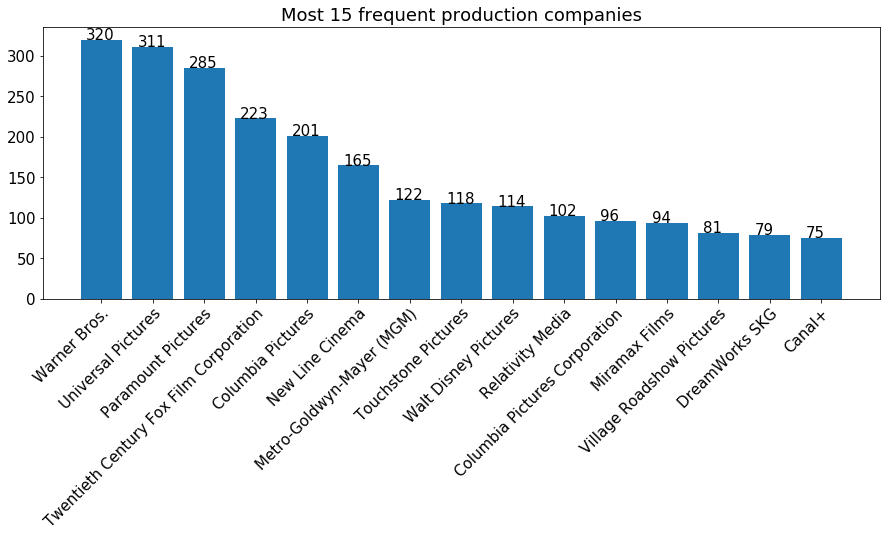

In [15]:
how_much_production = 15
column = "production_companies"
column_id = "production_companies_id"
most_freq_items_with_id(how_much_production, column, column_id)

Here are shown 15 most frequent production companies. The first three companies has made around 300 movies each which is nearly 20% of all the movies. The next three companies has made more than 150 movies each, and they are followed by the rest top companies who made 100 movies on average.

It seems like we have dominant production companies: Warner Bros. Universal Pictures and Paramount Pictures

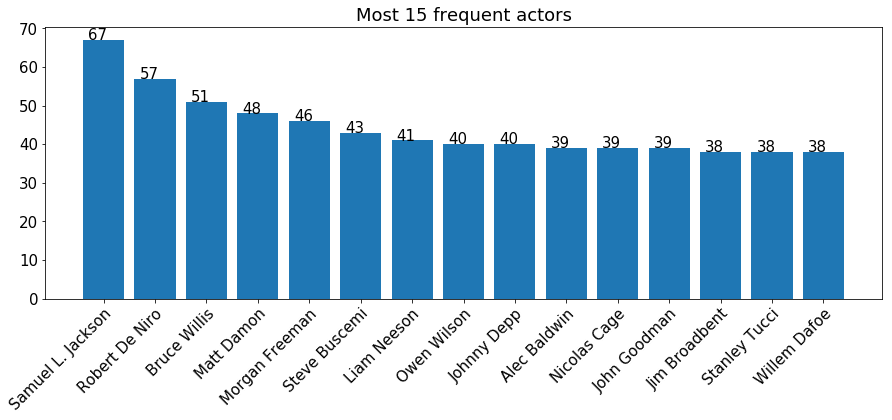

In [16]:
how_much_actors = 15
column = "actors"
column_id = "actors_id"
most_freq_items_with_id(how_much_production, column, column_id)

Here are shown 15 most frequent actors. All of them has shown up in more than 40 movies. The most frequent actor Samuel L. Jaskson has been in nearly 70 movies, after the distribution of the top actors slowly decrease

Here is the function which we use for representing most frequent how_much (i.e. 10) keywords, crew and genres. What we are looking for we will call the item in the comments and code (i.e. item is keyword crew_name or genre)

In [17]:
def most_freq_items(how_much, col):
    # how_much: how_much top frequent items fo we search for, type:int
    # col: name of the column in Movies dataframe i.e. "keywords", type:string
    # string_title: string for title "Most how_much frequent"+string_title i.e. string_title="keywords", type:string
    
    # This function will be used to find most frequent keywords, crew_names and genres
    # Here we will find the number of occurency of each keyword in database,
    # and store it in dictionary items_dict in pairs (item(type:str):number_of_occurency(type:int))
    items_dict = {}

    for i in range(len(Movies)):
        if(len(Movies.iloc[i][col])>0):
            for j in range(len(Movies.iloc[i][col].split(","))):
                if (len(Movies.iloc[i][col].split(","))>0):
                    item = Movies.iloc[i][col].split(",")[j]
                    items_dict[item] = items_dict.get(item, 0) + 1
    # Here we will find most how_much_items frequent keywords
    # We will "sort" the dictionary by values, retrieve the ids, and find the most frequent items from original dictionary
    
    how_much_items = how_much
    most_freq_items = sorted(items_dict, key=items_dict.get)[-how_much_items:]
    
    fig, ax = plt.subplots(figsize=(15,5))
    
    freq_items_plot = [items_dict[most_freq_items[len(most_freq_items)-1-i]] for i in range(how_much_items)]
    plt.bar(range(how_much_items), freq_items_plot)
    string_title = col.replace("_"," ")
    plt.title("Most {} frequent ".format(how_much_items) + string_title)
    if string_title == "main genres":
        plt.title("Histogram of main genres")
    plt.xticks(range(how_much_items),(most_freq_items[::-1]), fontsize=15, rotation=45, rotation_mode="anchor", ha="right")
    for i in ax.patches:
        ax.text(i.get_x()+.1, i.get_height(),str(round((i.get_height()))), fontsize=15, color='black')
    plt.show()

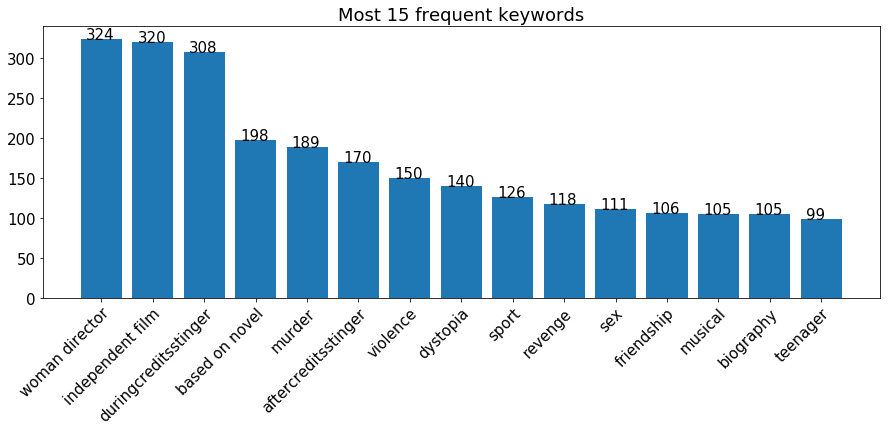

In [18]:
how_much_keywords = 15
column = "keywords"

most_freq_items(how_much_keywords, column)

We can see that some words are very frequent in keywords . Woman director is most used keyword, and having in mind that we have nearly 4800 movies, the women director shows up as keyword in nearly 7% of movies

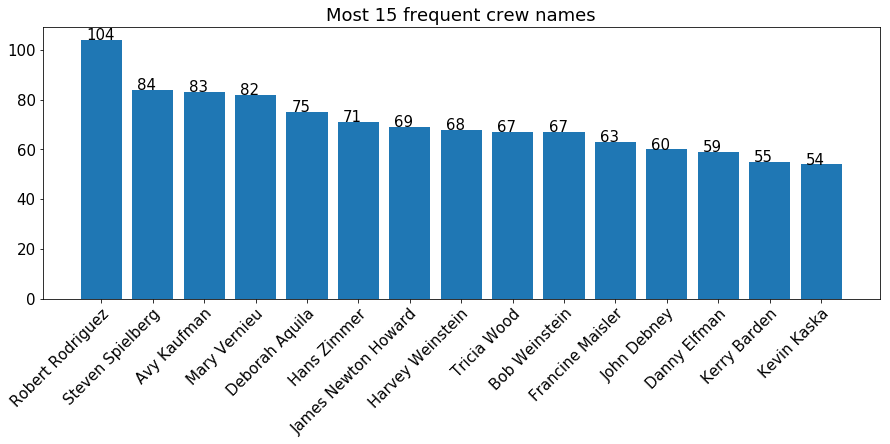

In [19]:
how_much_crew = 15
column = "crew_names"

most_freq_items(how_much_crew, column)

Here are shown the most frequent 15 crew names. Most working crew member is Robert Rodriguez with more than 100 movies, and the next member has been in nealry 80 movies. After these names, the number of different crew's movies slowly decrease form 80 to 60

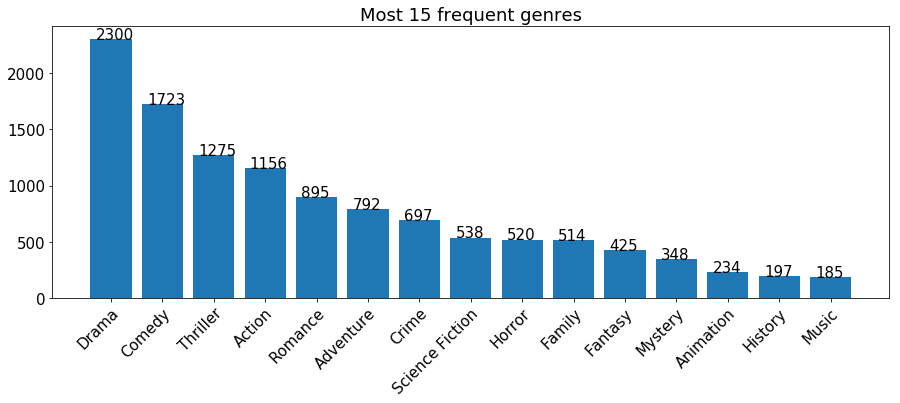

In [20]:
how_much_genre = 15
column = "genres"

most_freq_items(how_much_genre, column)

Drama, Comedy and Thriller are most frequent genres. It seems like more than 40% movies has drama in its genre description. But having in mind that the first genre is most meaningful one, we will present distribution of primary genres

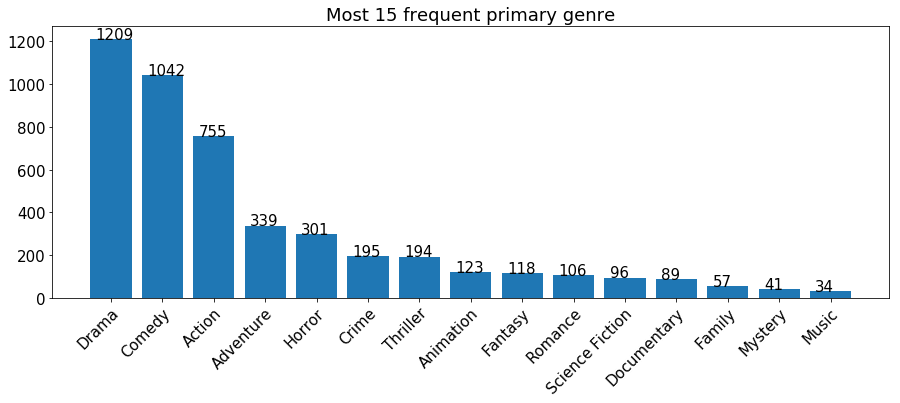

In [21]:
how_much_genre = 15
column = "primary_genre"
most_freq_items(how_much_genre, column)

In [22]:
genres_list = ["Drama","Action","Comedy","Adventure"]
genre_main = lambda x: x if (x in genres_list) else "Others"
main_genre = Movies["primary_genre"].apply(genre_main)
Movies["main_genres"] = main_genre

In [23]:
def get_genre(genre_list):
    genre_list = genre_list.split(",")
    for genre in genre_list:
        if genre =="Drama":
            return "Drama"
        if genre == "Action":
            return "Action"
        if genre == "Comedy":
            return "Comedy"
        #if genre == "Thriller":
        #    return "Thriller"
    return "Other"

list_genres = Movies["genres"].apply(get_genre)
print(len(list_genres))
Movies["main_genres"] = list_genres

4809


In [24]:
Movies["main_genres"].value_counts()

Drama     1650
Comedy    1345
Action    1040
Other      774
Name: main_genres, dtype: int64

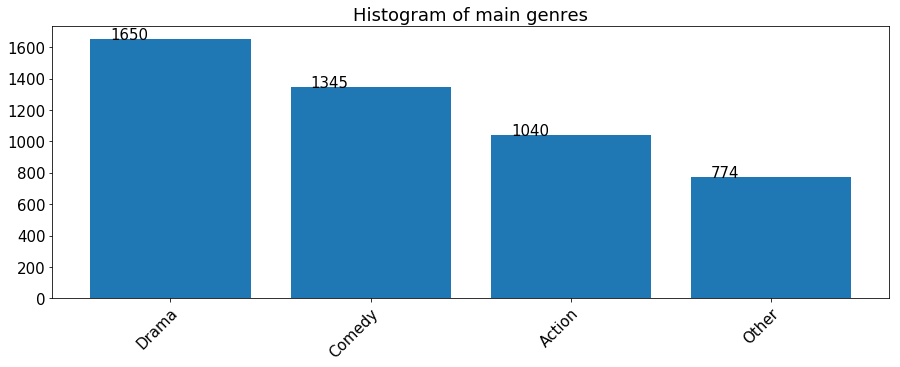

In [25]:
import matplotlib.pyplot as plt
how_much_genre = 4
column = "main_genres"
most_freq_items(how_much_genre, column)

Now we will look for correlation between numerical data such as budget, revenue, runtime, popularity, vote_average and vote_count. We expect to see high correlation between budget vs. revenue and popularity vs. vote_count, vote_average. Also not so high but still present correlation is expected at popularity vs. budget, revenue, and possible runtime vs popularity

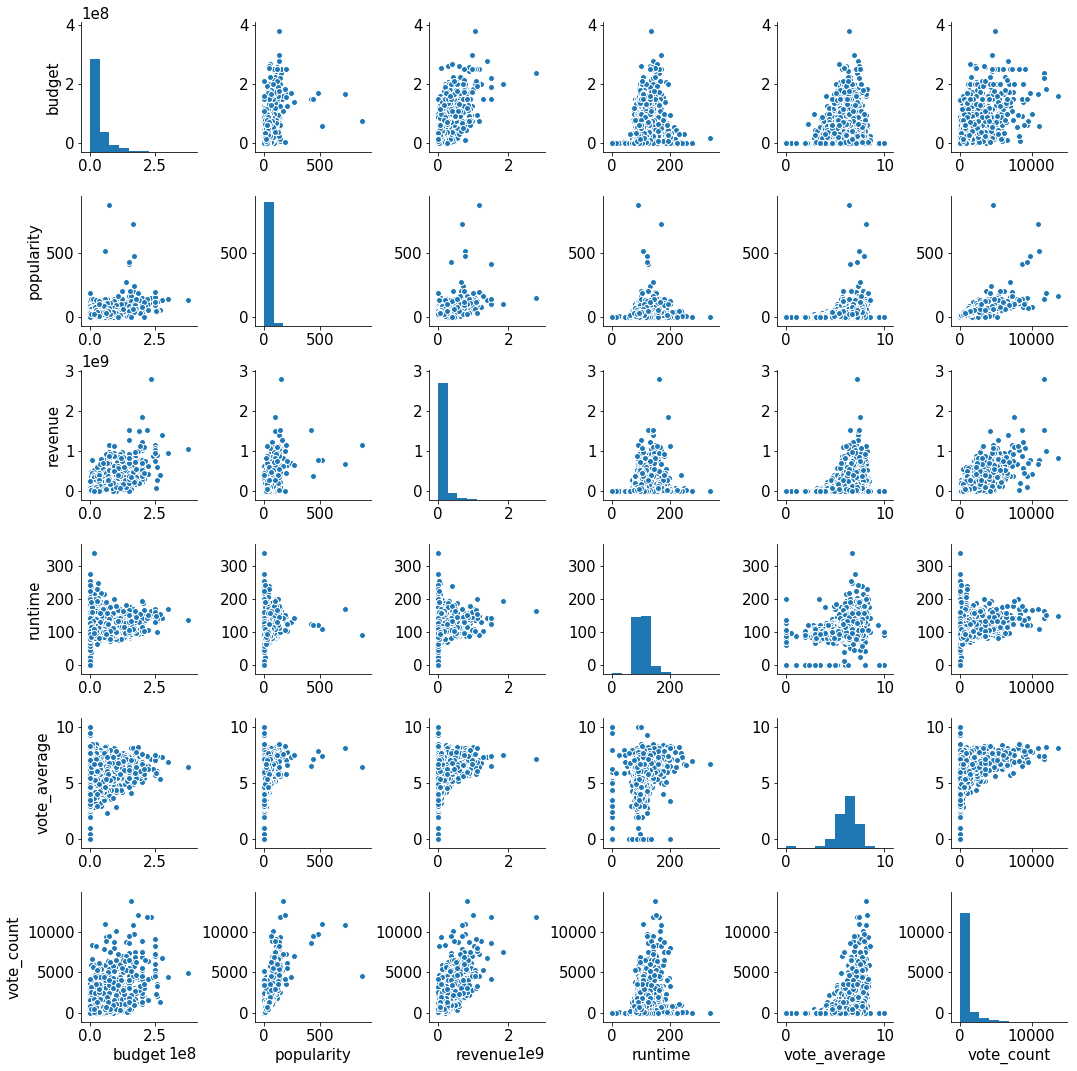

In [26]:
sns.pairplot(Movies[["budget","popularity","revenue","runtime","vote_average","vote_count"]].dropna())
plt.show()

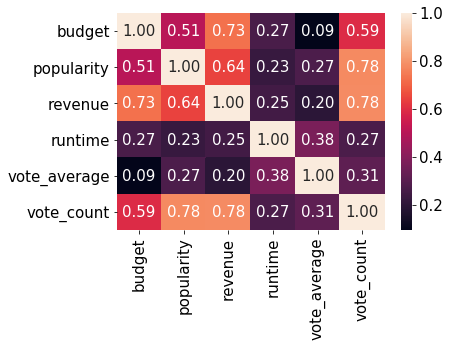

In [27]:
sns.heatmap(Movies.corr(), annot=True, fmt=".2f")
plt.show()

In the heatmap is quantified correlation between the data by Pearson coefficient. High value of correlation coefficents are obtained in case of: popularity vs vote_count, budget vs revenue, and slightly lower value in case of popularity vs revenue vote count vs budget, popularity vs budget. Because between these data there exist some relatively high correlation, we can pick just some of attributes as features, and lower dimensionality of our feature vector without losing to much information

In [28]:
# How many movies have tagline
len(Movies["tagline"].dropna())

3965

Since many movies do not have a tagline and some words from tagline are included in the keywords, we will not use taglines

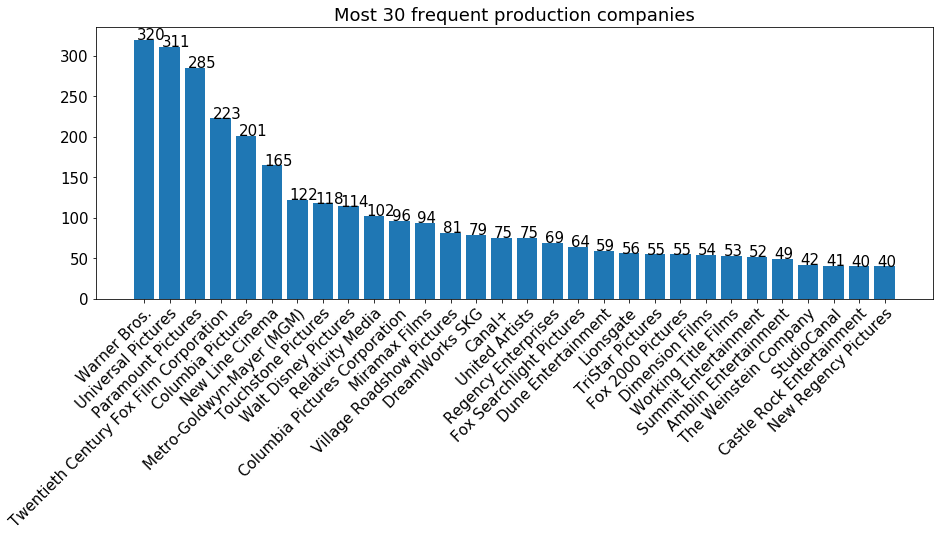

In [29]:
how_much_production = 30
column = "production_companies"
column_id = "production_companies_id"
most_freq_items_with_id(how_much_production, column, column_id)

Here we will present most frequent production countries

The most movies comes from the United States of America. We believe that with including this attribute we would get unbalanced set, hence this attribute will not be included in feature vector

Original language of the movie is the movie language that is most of time spoken.Here we will present the most frequent original languages

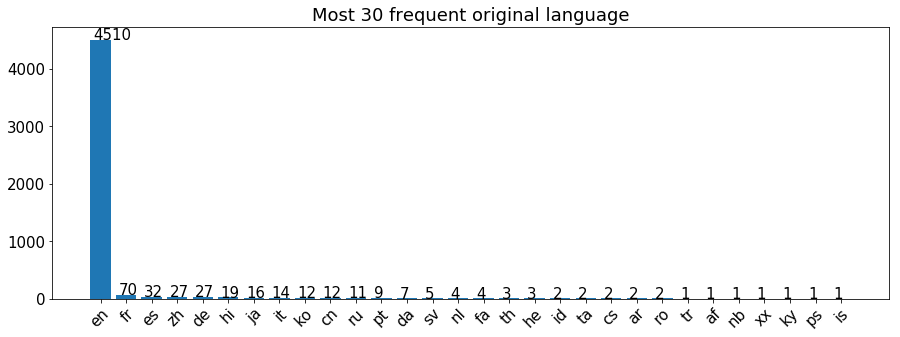

In [30]:
how_much_lang = 30
column = "original_language"
most_freq_items(how_much_lang, column)

The dominant language is English with frequency greater than 90%. From the same reason as before,original language we will not include in the feature vector. Moreover, we do not expect other attributes such that: realise date, runtime are connected with movies genre

In [31]:
Drops = ['release_date','runtime','budget','popularity', "original_language", "tagline", 'spoken_languages']
for drop in Drops:
    Movies = Movies.drop(drop, 1)

## Data Expoitation and Evaluation

Two major data exploitation are considered: 
    1. Investigation of possibilty of using graph based on movies for genres classification
    2. Construction of movie recommendation engine suggesting the next movie to watch

## Investigation of possibility of genres classification

The graph clusstering method is investigated to in order to assess feasibility of classification leading to genre prediction using a selection of movie attributes. Prove of concept example below demostrates on indeal situation, where the graph contains only information of movie genre and nothing else, it is possible to use spectral clusterring method to assess the movie of the genre. Realistic scenario where we include all movie attributes without including genres is investigated later on.

Remaining % of movies: 0.9976574700676731


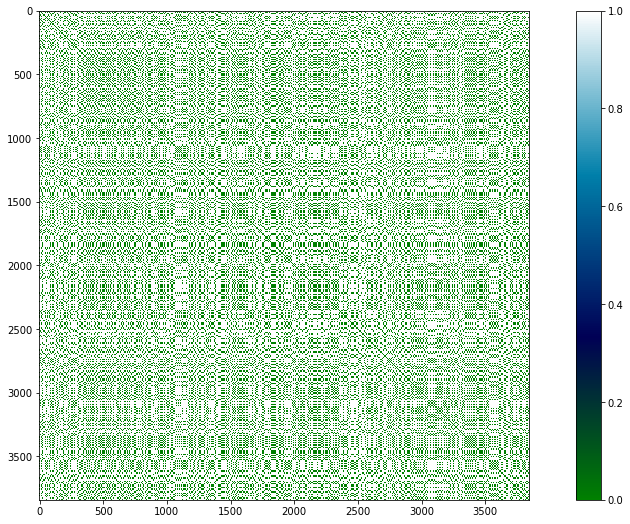

0.729239228549


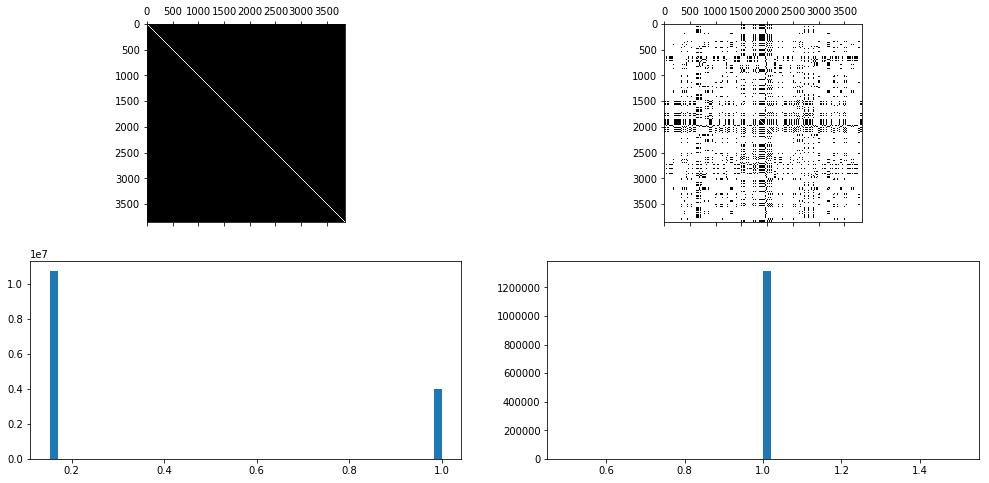

In [163]:
#simplistic example
#DropLines=[]
Remains= (Movies.drop(DropLines))
Cat_remains = pd.DataFrame()
Cat_remains['Is_drama']   = Remains["main_genres"].apply(lambda x: 1 if x=='Drama'  else 0)
Cat_remains['Is_Comedy']  = Remains["main_genres"].apply(lambda x: 1 if x=='Comedy' else 0)
Cat_remains['Is_Action']  = Remains["main_genres"].apply(lambda x: 1 if x=='Action' else 0)
Cat_remains['Is_Other']   = Remains["main_genres"].apply(lambda x: 1 if x=='Other'  else 0)

#calculation of distances betseen movies in the genre spece using cosine metric, lines which contain only zeroes
#are removed from the dataset since zero vectors are not valid input for cosine distance calculation
Simple_distances, DL, NF = DropZeroLinesAndGetDistanes([Cat_remains,Cat_remains,Cat_remains])

PlotMatrix(Simple_distances[0])
#calculation the weight matrix from distances using gaussian kernel
SimpleW =  GetWeights(Simple_distances[0],5000-967)
simpleWEIGHTS = SimpleW
np.savez_compressed("../Datasets/simpleWEIGHTS.npz", simpleWEIGHTS, simpleWEIGHTS=simpleWEIGHTS)


In [164]:
Simple_genres = preprocessing.LabelEncoder().fit_transform((Movies.drop(DropLines)['main_genres']))
print(Simple_distances[0][0][-1])
print(simpleWEIGHTS[0][-1])
print(Simple_genres[0])
print(Simple_genres[-1])

1.0
0.0
1
0


[1 2 1 1 2 2 0 2 2 1 0 3 0 0 1 2 0 0 0 1 2 1 3 0 2 2 1 2 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


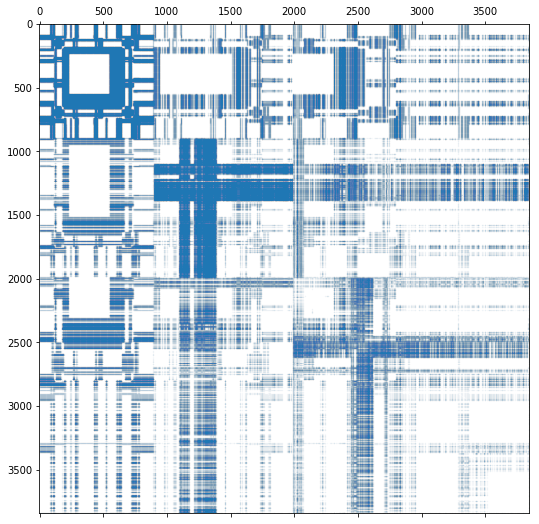

In [165]:
#getting genres encoding
genres = preprocessing.LabelEncoder().fit_transform((Movies.drop(DropLines)['main_genres']))
#saving the matrix
np.savez_compressed("../Datasets/Simple_genres.npz", genres, genres=genres)
Sorted_simpleWEIGHTS = BubbleReorderMatrix(SimpleW,genres)  
plt.spy(Sorted_simpleWEIGHTS, markersize=0.005)

After obtaining sparse matrix, we follow the first algorithm for unnormalized spectral classtering proposed in the [tutorial](www.cs.cmu.edu/~aarti/Class/10701/readings/Luxburg06_TR.pdf) page 5

Score is  0.322728217925


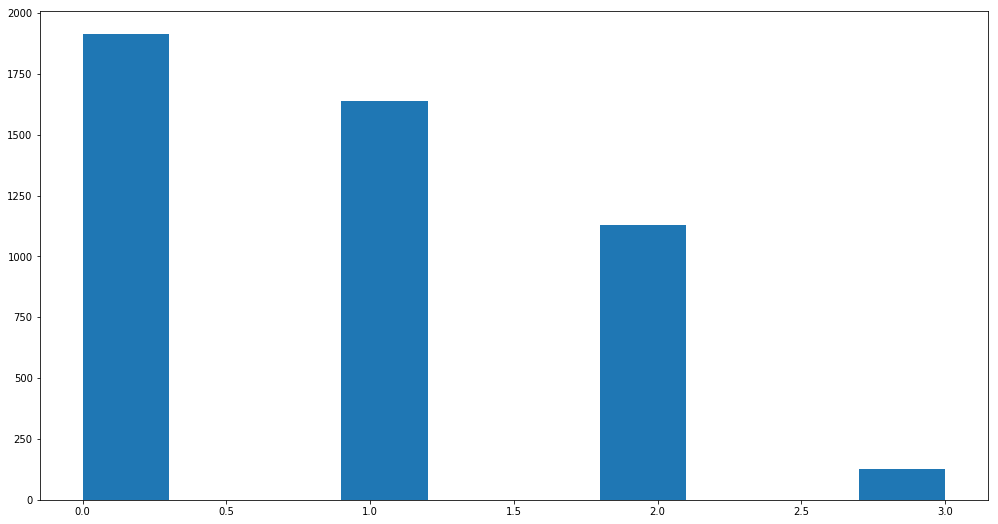

In [146]:
simpleWEIGHTS = SimpleW

weights_sparse = simpleWEIGHTS

#laplacian preparation
degrees = np.count_nonzero(weights_sparse, axis=0)
D = np.diag(degrees)
laplacian_comb = D - weights_sparse

#calculation of eigenvalues and eigenvectors
how_much_genre = 4
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(laplacian_comb, how_much_genre, which='SM')

#applying the kmeans algorithm
kmeans = KMeans(n_clusters=how_much_genre).fit(eigenvectors)
simple_l =kmeans.labels_
(Movies.drop(DropLines)).iloc[simple_l==3]
plt.hist(simple_l)
#generating the score estimate
genres = preprocessing.LabelEncoder().fit_transform((Movies.drop(DropLines)['main_genres']))
print("Score is ",f1_score(genres, matchLabel(simple_l,genres),average='micro'))
#Calculate metrics globally by counting the total true positives, false negatives and false positives.


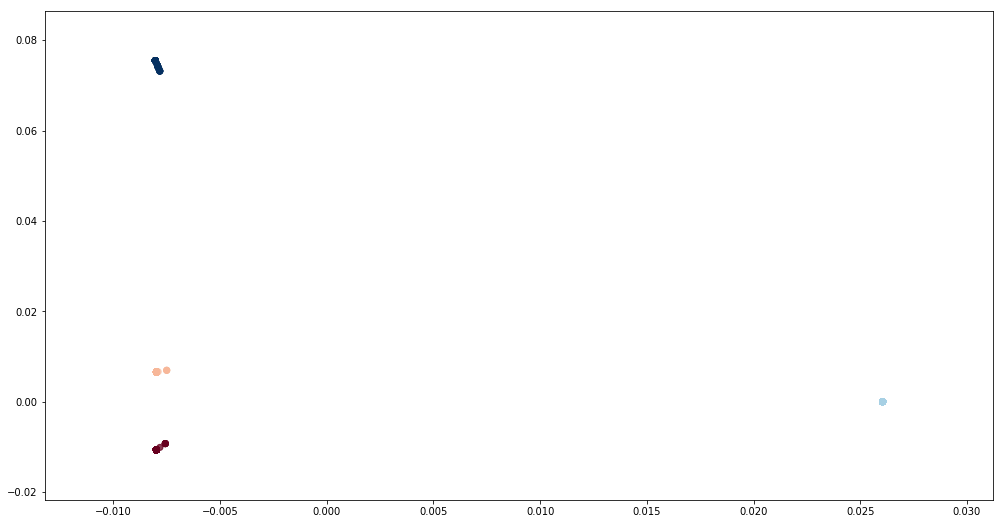

In [147]:
#visualization of movies
genres = preprocessing.LabelEncoder().fit_transform((Movies.drop(DropLines)['main_genres']))

features_pca = decomposition.PCA(n_components=2).fit_transform(eigenvectors)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=simple_l, cmap='RdBu', alpha=0.5)
plt.show()

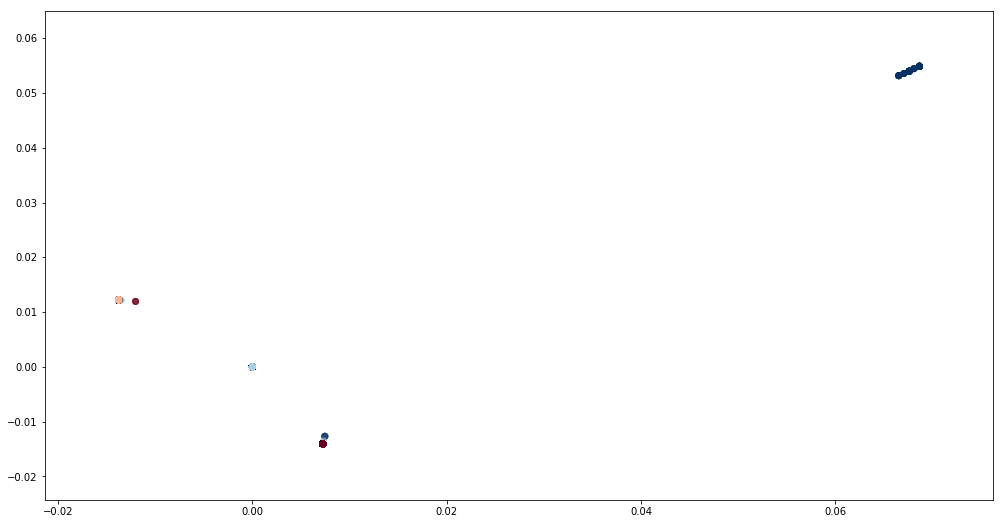

In [148]:
genres = preprocessing.LabelEncoder().fit_transform((Movies.drop(DropLines)['main_genres']))

features_pca = decomposition.PCA(n_components=2).fit_transform(eigenvectors)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=genres, cmap='RdBu', alpha=0.5)
plt.show()

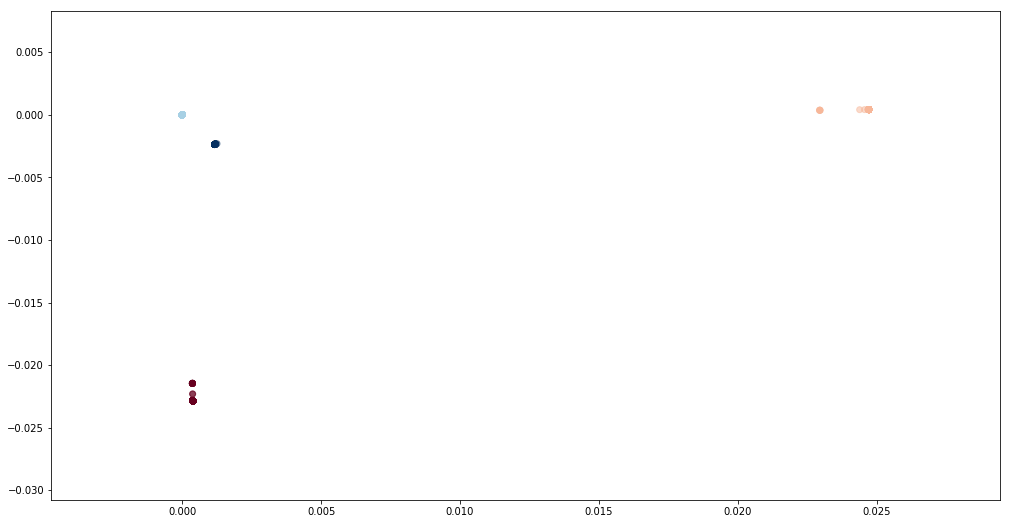

In [149]:
plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=simple_l, cmap='RdBu', alpha=0.5)
plt.show()

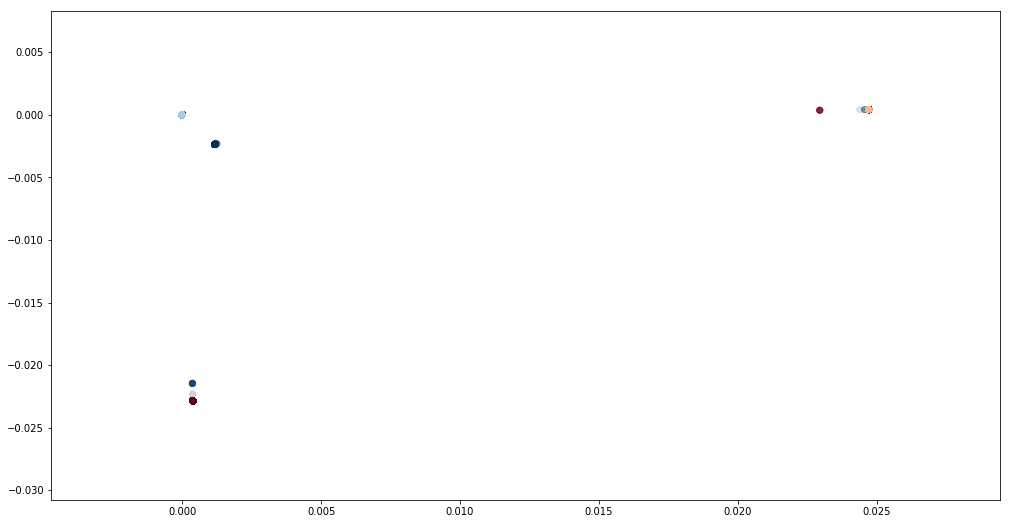

In [150]:
plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=genres, cmap='RdBu', alpha=0.5)
plt.show()

From our visualization of the simplistic scenario we see that the method has a potential for separation however, it is necessary to provide an input dataset which contains the information sufficien for genre classification

For the realistic scenario we need to select features from which distance matrix is constructed.

Here we are choosing which data should be included in the feature vector. In order to categorize the movie's genre the feature vector contains data about $N$ actors $M$ crew members and $K$ keywords, and these numbers are optimized manually in multiple itterations aiming to achieve best classification accuracy. Results of classification highly depends on these parameters.

More specficallty, aim is that we determine the main genre which is the first genre of Drama, Comedy, Romance. We have dropped some rows that has i.e. movies that has only one actor who does not play in other movies. The all_distances matrix contains three smaller matrix that has cosine distances between only actors, crew memebers and keywords, respectively

In order to maximize accuracy we calculate distance from selection of features. Since many features are categorical with many possible categories. To allow for efficient calculation of similarity, the categorical variables are transformed in a way that every possible category outcomes becomes a new column in the frame and then all collumns are combined into one dataframe which is later on a subject to PCA transformation in order to reduce the dimensionalty which after mentioned trasformation was beyond computable limits

In [65]:
#Example:
#Actors=['Bruce Willis','Jim Carry'] --> Is_BruceWillis =1
#                                        Is_JimCarry    =1
#                                        Is_JuliaRoberts=0
#                                        ....           =0

Merging Started
Category processed
Merging Started
Category processed
Merging Started
Category processed
DONE
Remaining % of movies: 0.7970472031607403


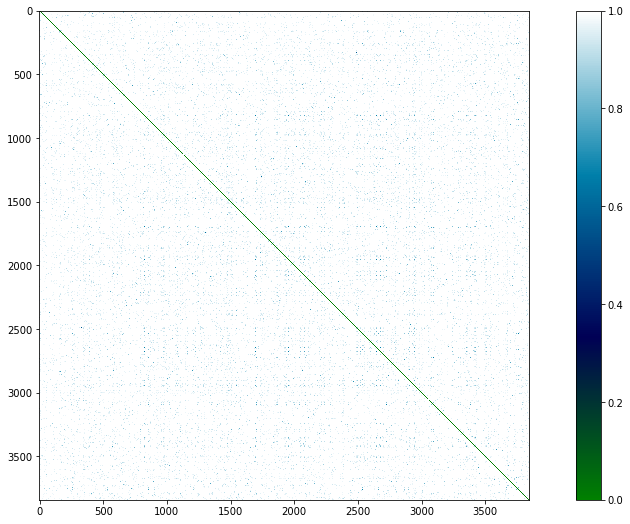

In [161]:
Movies['actors']               = Movies['actors'].apply(lambda x: x.replace(" ", "_"))
Movies['keywords']             = Movies['keywords'].apply(lambda x: x.replace(" ", "_"))
Movies['crew_names']           = Movies['crew_names'].apply(lambda x: x.replace(" ", "_"))
Movies['production_companies'] = Movies['production_companies'].apply(lambda x: x.replace(" ", "_"))

Frames = []
for feature in ['prime_actors','prime_keywords','prime_crew_names']:
    Frames.append(((ProcessCategorical(Movies,feature)).fillna(0)))
         
print("DONE")

all_distances, DropLines, newFrames = DropZeroLinesAndGetDistanes(Frames)
genres = preprocessing.LabelEncoder().fit_transform((Movies.drop(DropLines)['main_genres']))

%matplotlib inline
#distaces in Actors
#PlotMatrix(all_distances[0])
#distaces in keywords
#PlotMatrix(all_distances[1])
#distaces in crew
#PlotMatrix(all_distances[2])

CatDistances = (all_distances[0] + all_distances[1] + all_distances[2])/3
#categorical distances
PlotMatrix(CatDistances)

The distribution of the squared distances is presented here:

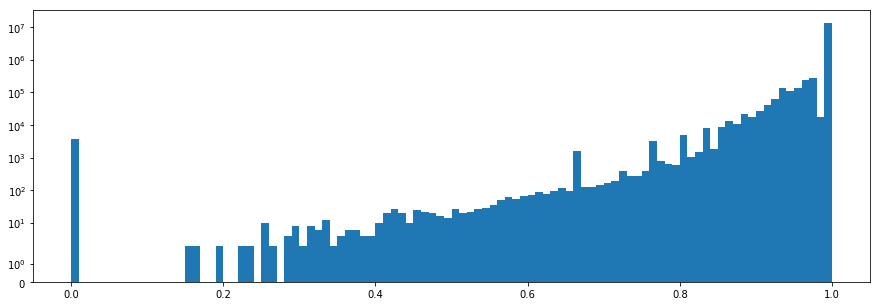

In [67]:
#CatDistance distribution
fig, axes = plt.subplots(figsize=(15, 5))
axes.set(yscale="symlog")
plt.rcParams['figure.figsize'] = (17, 9)
plt.hist(CatDistances.reshape(-1), bins=100);

Here we use kNN method to sparsify the distance matrix. The our algortihm is extremly sensitive to the vlaue of this parameter

0.995480235795


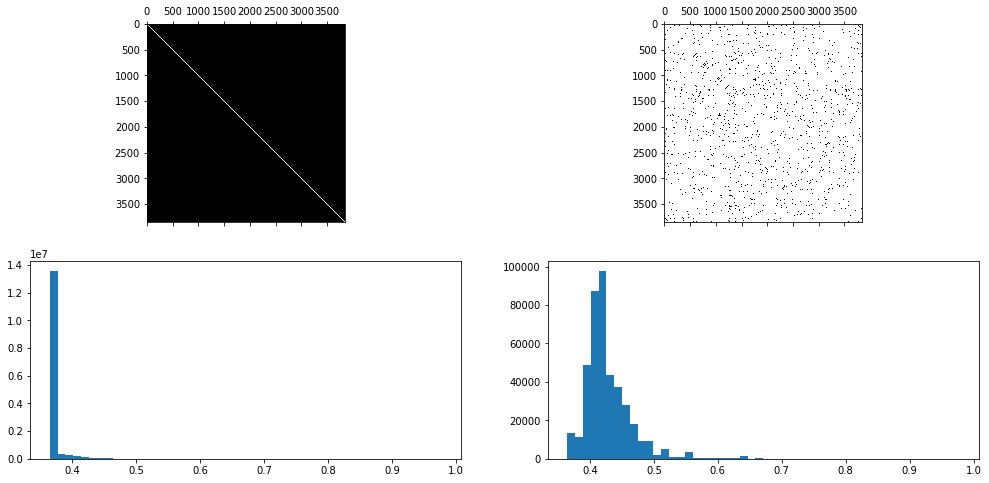

In [151]:
#getting raw categorical weights
NEIGHBORS = 80 #!WARNING extremly sensitive parameter    
RawCatweights = GetWeights(CatDistances,NEIGHBORS)


#Combining numerical and categoriacl features, leading to now improvment
features = pd.DataFrame()

#including

#for col in ['revenue', 'vote_average',  'vote_count']:
#    features[col]      = (Movies.drop(DropLines))[col] 
#features -= features.mean(axis=0)
#features /= features.std(axis=0)

for df in newFrames:
    features[df.columns] = df[df.columns]

It t was investigated tha including numerical features does not lead to improvements

The feature vector is high dimensional vector, and due to this factor we decide to use PCA to obtain some lower dimensional representation. We will keep first 80 PCA components and calclate cosine distance on them

In [152]:
Catfeatures_pca = decomposition.PCA(n_components=80).fit_transform(features)
PCA_Cat_distances =scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Catfeatures_pca, metric='cosine') )

Here we present the histogram on new features distance obtained by usfar applying PCA

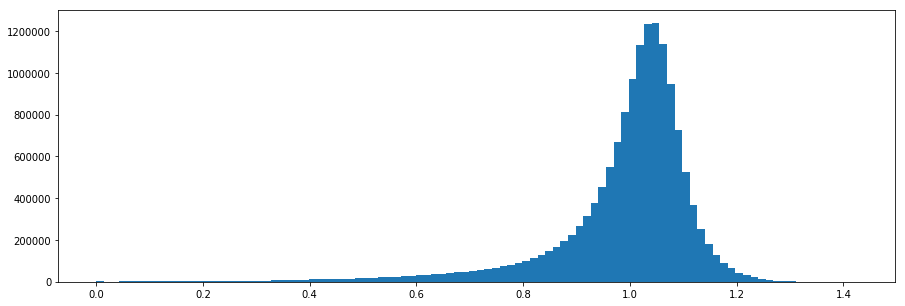

In [153]:
#PCA_Cat_distances distribution
fig, axes = plt.subplots(figsize=(15, 5))
#axes.set(yscale="symlog")
plt.rcParams['figure.figsize'] = (17, 9)
plt.hist(PCA_Cat_distances.reshape(-1), bins=100);

After obtaining new features using PCA, we will sparsify the adjacency matrix using kNN method. Our algorithm is very sensitive to the number of neighbours

0.990130535082


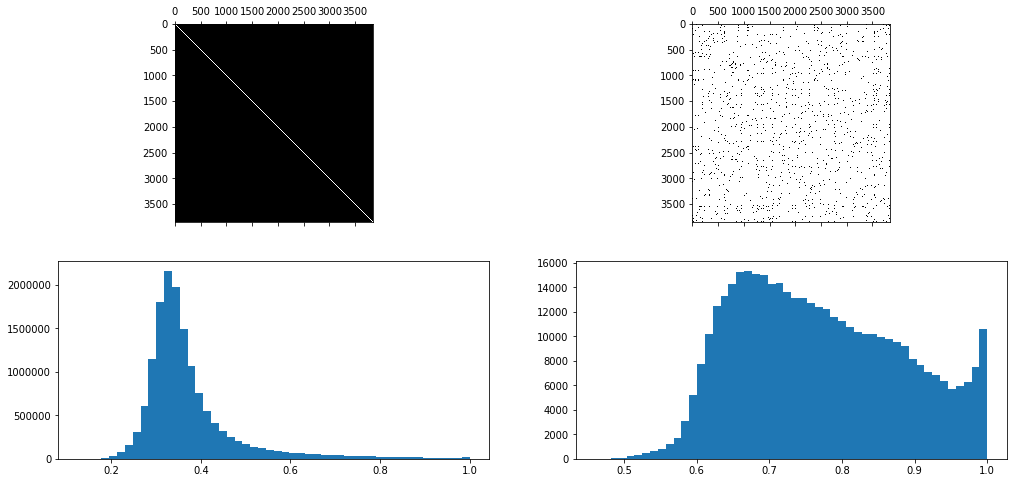

In [154]:
#getting PCA categorical weights
NEIGHBORS = 80 #!WARNING extremly sensitive parameter    
PCACatweights = GetWeights(PCA_Cat_distances,NEIGHBORS)

Let's take a look at new sparsified adjacency matrix

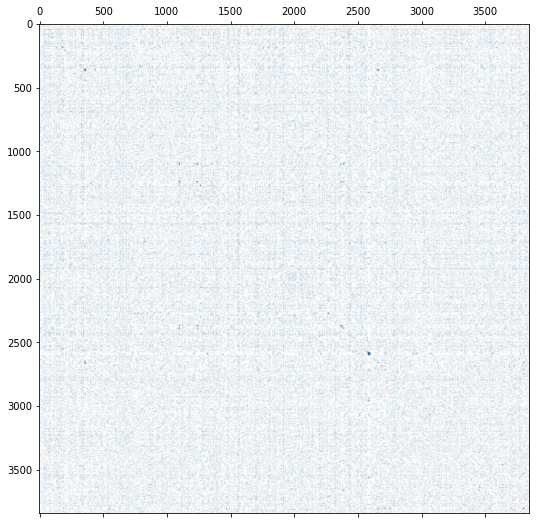

In [155]:
plt.spy(PCACatweights, markersize=0.01)

Here we will reorder the matrix to get as close as possible diagonal matrix which should tell us how much weakly connected or disconnected components are there

[2 1 2 2 1 1 0 2 2 0 2 2 1 0 3 0 0 1 1 2 2 0 2 0 0 1 3 2 1 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


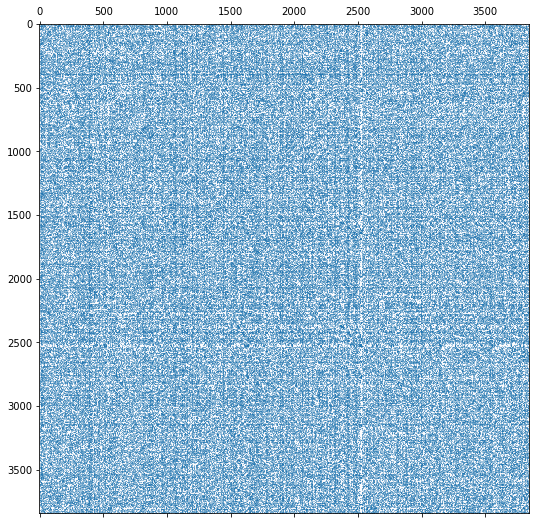

In [156]:
genres = preprocessing.LabelEncoder().fit_transform((Movies.drop(DropLines)['main_genres']))            
Sorted_Full_WEIGHTS = BubbleReorderMatrix(PCACatweights,genres) 
np.savez_compressed("../Datasets/WEIGHTS.npz", WEIGHTS, WEIGHTS=WEIGHTS)

plt.spy(Sorted_Full_WEIGHTS, markersize=0.1)
#PlotMatrix(WEIGHTS)

After reordering raws and column in the matrix it was not possible to find the clear squares representing separated genres. Given that genre other is a combination of all poorly populated genres the absence of the last square is understandable

In [157]:
weights_sparse = PCACatweights

degrees = np.count_nonzero(weights_sparse, axis=0)
D = np.diag(degrees)
laplacian_comb = D - weights_sparse

how_much_genre = 4
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(laplacian_comb, how_much_genre, which='SM')


kmeans = KMeans(n_clusters=how_much_genre).fit(eigenvectors)
l =kmeans.labels_
#(Movies.drop(DropLines)).iloc[l==3]

,genres,keywords,original_title,overview,production_companies,production_countries,revenue,vote_average,vote_count,genres_id,...,crew_names,crew_names_id,crew_jobs,crew_departments,primary_genre,primary_production_company,prime_actors,prime_crew_names,prime_keywords,main_genres
title,,,,,,,,,,,,,,,,,,,,,
102 Dalmatians,"Comedy,Family","london_england,prison,release_from_prison,wome...",102 Dalmatians,Get ready for a howling good time as an all ne...,"Walt_Disney_Pictures,Cruella_Productions",United States of America,183611771,5.1,313,"35,10751",...,"David_Newman,Adrian_Biddle,Kevin_Lima,Gregory_...","3393,7783,15775,15779,11302,60534,60534,60543,...","Music,Director of Photography,Director,Editor,...","Sound,Camera,Directing,Editing,Production,Writ...",Comedy,Walt Disney Pictures,"Glenn Close,Ioan Gruffudd,Alice Evans,Tim McIn...","David Newman,Adrian Biddle,Kevin Lima,Gregory ...","london england,prison,release from prison,wome...",Comedy
21,"Drama,Crime","gambling,card_game,professor,harvard_universit...",21,"Ben Campbell is a young, highly intelligent, s...","Columbia_Pictures,Relativity_Media",United States of America,69823199,6.5,1375,"18,80",...,"Francine_Maisler,Michael_De_Luca,Missy_Stewart...","6410,4767,6628,8523,16618,10837,11091,33281,34...","Casting,Producer,Production Design,Director of...","Production,Production,Art,Camera,Crew,Art,Prod...",Drama,Columbia Pictures,"Jim Sturgess,Kevin Spacey,Kate Bosworth,Aaron ...","Francine Maisler,Michael De Luca,Missy Stewart...","gambling,card game,professor,harvard universit...",Drama
3 Days to Kill,"Action,Drama,Thriller,Crime","retirement,secret_service,illegal_drugs",3 Days to Kill,A dangerous international spy is determined to...,"Wonderland_Sound_and_Vision,EuropaCorp,Relativ...","France,United States of America",52597999,6.0,883,"28,18,53,80",...,"Luc_Besson,Luc_Besson,Luc_Besson,Thierry_Arbog...","59,59,59,997,6959,36425,20722,21650,23365,4629...","Screenplay,Story,Producer,Director of Photogra...","Writing,Writing,Production,Camera,Production,D...",Action,Wonderland Sound and Vision,"Kevin Costner,Amber Heard,Hailee Steinfeld,Con...","Luc Besson,Luc Besson,Luc Besson,Thierry Arbog...","retirement,secret service,illegal drugs",Action
A Scanner Darkly,"Animation,Science Fiction,Thriller","california,detective,based_on_novel,dream,unde...",A Scanner Darkly,An undercover cop in a not-too-distant future ...,"Thousand_Words,Warner_Independent_Pictures_(WI...",United States of America,7659918,6.8,532,"16,878,53",...,"Denise_Chamian,Richard_Linklater,Richard_Linkl...","2215,564,564,580,566,584,3727,1461,1884,2946,1...","Casting,Screenplay,Director,Editor,Producer,No...","Production,Writing,Directing,Editing,Productio...",Animation,Thousand Words,"Keanu Reeves,Winona Ryder,Woody Harrelson,Robe...","Denise Chamian,Richard Linklater,Richard Linkl...","california,detective,based on novel,dream,unde...",Other
A Shine of Rainbows,"Drama,Family","orphan,rainbow",A Shine of Rainbows,An orphaned boy named Tomás is adopted by Mair...,"Octagon_Films,Sepia_Films","Canada,Ireland",0,6.3,14,"18,10751",...,"Vic_Sarin,Vic_Sarin,Catherine_Spear,Morgan_O'S...","87121,87121,563649,953724","Director,Writer,Writer,Executive Producer","Directing,Writing,Writing,Production",Drama,Octagon Films,"Connie Nielsen,Aidan Quinn,John Bell,Tara Alic...","Vic Sarin,Vic Sarin,Catherine Spear,Morgan O'S...","orphan,rainbow",Drama
A Walk to Remember,"Drama,Romance","based_on_novel,theatre_group,north_carolina,th...",A Walk to Remember,"When the popular, restless Landon Carter is fo...","DiNovi_Pictures,Pandora_Pictures,Gaylord_Films...",United States of America,41227069,7.5,1018,"18,10749",...,"Denise_Di_Novi,Edward_McDonnell,Julio_Macat,Hu...","1899,4588,11506,18350,20739,20744,35665,81295,...","Producer,Executive Producer,Director of Photog...","Production,Production,Camera,Production,Direct...",Drama,DiNovi Pictures,"Mandy Moore,Shane West,Peter Coyote,Daryl Hann...","Denise Di Novi,Edward McDonnell,Julio 

In [82]:
genres = preprocessing.LabelEncoder().fit_transform((Movies.drop(DropLines)['main_genres']))
#for i in range(len(genres)):
#    print(genres[i],l[i])

(array([ 3638.,     0.,     0.,    63.,     0.,     0.,    43.,     0.,
            0.,    98.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

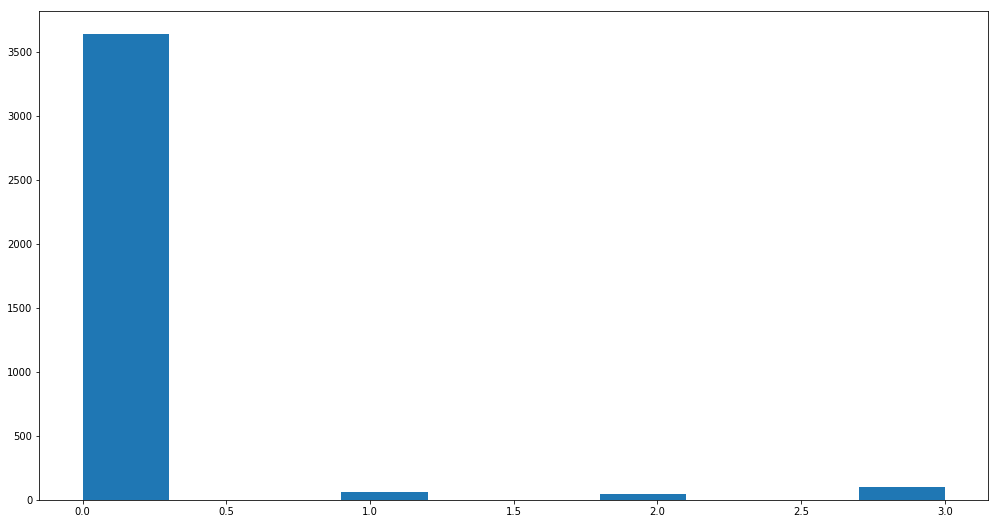

In [83]:
plt.hist(l)

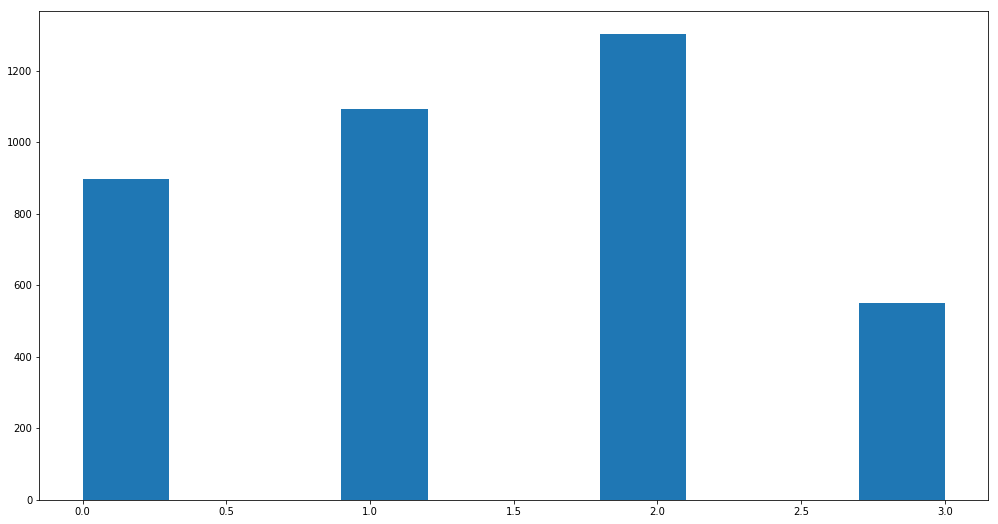

In [84]:
plt.hist(genres)
genres = preprocessing.LabelEncoder().fit_transform((Movies.drop(DropLines)['main_genres']))


We observe there is no agreement between distributions of genre populations between predicted and groud truth populations which is most likely result of clustering on data which do not covey the necessary information clearly enough for a pattern to be found.

In [85]:
f1_score(genres, matchLabel(l,genres),average='micro')
#Calculate metrics globally by counting the total true positives, false negatives and false positives.

0.3305570015616866

As it is unclear which cluster number corresponds to which genres, we try to associate them by order of number of entries:

In [86]:
genres = preprocessing.LabelEncoder().fit_transform((Movies.drop(DropLines)['main_genres']))
print("Score is ",f1_score(genres, matchLabel(l,genres),average='micro'))


Score is  0.330557001562


However this assumption is not assured, therefore we test for all possible configurations to see whether other caluster-genre correspondace results it beter accuracy:

In [87]:
bestScore=0
for i in range(4):
    for j in range(4):
        if j == i:
            continue
        for k in range(4):
            if k==j:
                continue
            if k==i:
                continue 
            for m in range(4):
                if m==j:
                    continue
                if m==i:
                    continue
                if m==k:
                    continue
                for entry in range(len(l)):
                    if l[entry] == 0:
                        l[entry]=i
                    if l[entry] == 1:
                        l[entry]=k
                    if l[entry] == 2:   
                        l[entry]=j
                    if l[entry] == 3:
                        l[entry]=m
                    if bestScore < f1_score(genres, l,average='micro'):
                        bestScore = f1_score(genres, l,average='micro')
                        
print("Score is ",bestScore)

Score is  0.340968245705


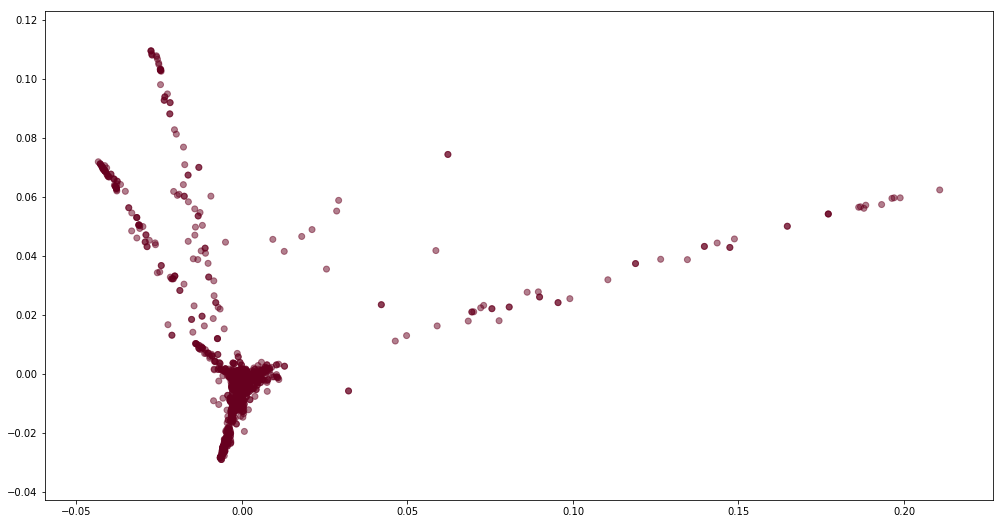

In [88]:
features_pca = decomposition.PCA(n_components=2).fit_transform(eigenvectors)
genres = preprocessing.LabelEncoder().fit_transform(l)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=l, cmap='RdBu', alpha=0.5)
plt.show()

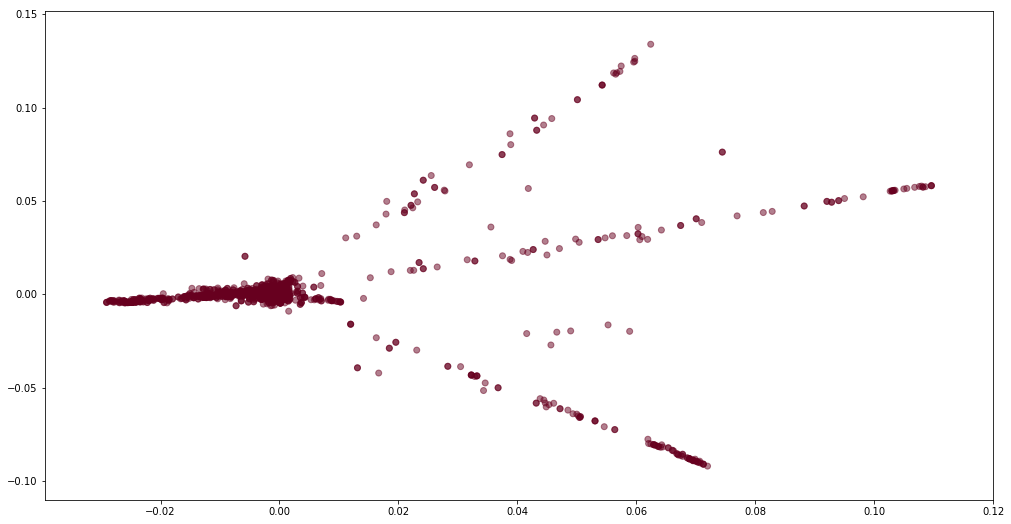

In [89]:
features_pca = decomposition.PCA(n_components=2).fit_transform(eigenvectors)
genres = preprocessing.LabelEncoder().fit_transform(l)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=genres, cmap='RdBu', alpha=0.5)
plt.show()

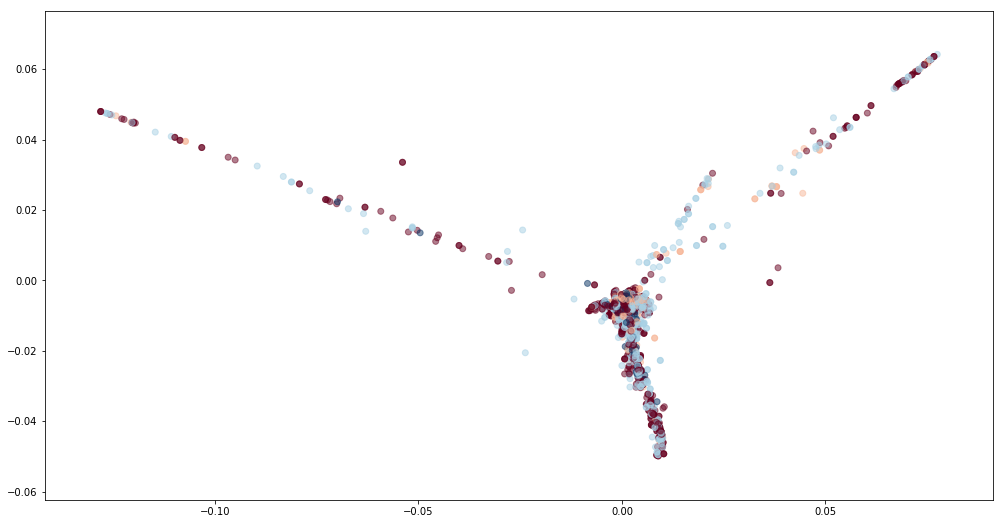

In [90]:
plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=simple_l, cmap='RdBu', alpha=0.5)
plt.show()

Given that the best prediction is accuracy ~30% the described method when only simple features characterising the movies are in use. Low accuracy can be explain by several factors. Firstly, it is construction of the main genre which is used for scoring, in this construction we use take only one genre despite the movie is tagged with more than one. Secondly, one of main genres is "other" which is a commulative genre for many poorly populated genres. Thirdly, the numbers of representative actors, crew members and keywords has been tested with numerous configurations however there is no gaurantee that the best found configuration is optimal. Also, the number nearest neighbours plays a crucial role in visibility of the squares in the ordered weight matrix. Therefore, is seems like more advanced features such as audiovisual samples might be necessary in order to have accurate movie classification based purely on simple graph analysis.

## Construction of movie recommendation engine

In [ ]:
##

In [94]:
import pickle
with open('../Datasets/DropLines.pkl', 'wb') as f:
    pickle.dump(DropLines, f)

In [162]:
len(DropLines)

967

1.0

2

1

## Conclusion

The possibily of genre classification using only simple movie attributes was investigated however the accuracy of calssication is found to be ~30% which signalizes that using this method on dataset of simple atributes is not a good option